Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "SIDDHARTH YASHASWEE"
COLLABORATORS = ""

---

# Dimensionality Reduction
In this exercise you will implement PCA, MDS and IsoMap.
The imported libraries below are sufficient to solve the tasks. You are not allowed to use any additional libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import k3d
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
np.random.seed(42)

## PCA
For PCA we consider a set of 64x64 images of different faces. You can see an example below.
You will have to implement the functions `compute_principal_components`, `project_pca`, and `unproject_pca`.
`compute_principal_components` returns a $d\times k$ matrix, consisting of the $k$ principal components that are the orthogonal basis of the embedding space. Each principal component is thus $d$-dimensional. Projecting the vectors in the datasets results in $k$-dimensional embeddings. In order to reconstruct vectors of the original $d$-dimensional size (from the lower dimensional projected $k$-dimensional ones), you can use the transpose of your computed principal components matrix. To compute the singular value decomposition you can use `np.linalg.svd` (see the documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)). Alternatively, if you prefer to compute the eigendecomposition you can use `np.linalg.eigh` (see the documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)).

For 2D plots $k=2$. However, you can also try out higher values (e.g. $k=32$ or $k=100$). Then the reconstructions should be closer to the original face images.

In [3]:
###FOR SOLUTION USING SVD, see the official solution
faces = np.load("faces.npy")
print(faces.shape)

(400, 4096)


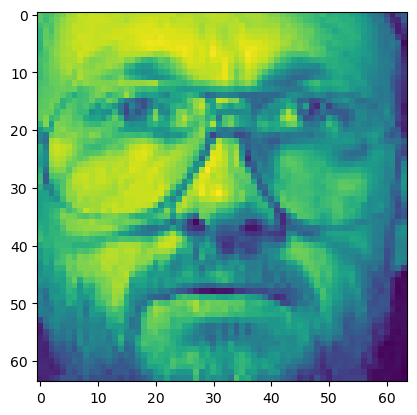

In [4]:
plt.imshow(faces[0].reshape(64,64))

In [5]:
K = np.array([1,8,2,4,5,5,6,10])
#prints indices of sorted array(asc), last 5 items, items from 5th element to last(see slicing in numpy)
np.sort(K), np.argsort(K), np.argsort(K)[-5:], np.argsort(K)[5:]

(array([ 1,  2,  4,  5,  5,  6,  8, 10]),
 array([0, 2, 3, 4, 5, 6, 1, 7], dtype=int64),
 array([4, 5, 6, 1, 7], dtype=int64),
 array([6, 1, 7], dtype=int64))

In [6]:
def compute_principal_components(data, n_components):
    ### YOUR CODE HERE - see slides for logic used
    n_img = data.shape[0]
    J = np.eye(n_img) - np.ones((n_img, n_img))/n_img
    #print(J.shape) - 400x400
    
    C = (data.T@J@J.T@data)/n_img
    #print(C.shape) - 4096x4096
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    
    eigenindex = np.argsort(eigenvalues)[-n_components:]
    #print(eigenindex.shape) - (2,)

    #print(eigenvectors.shape) - 4096x4096
    pc = eigenvectors[:, eigenindex]
    
    #print(pc.shape) - 4096x2- asserted value wont change, change others instead
    return pc
    
def project_pca(data, pc):
    n_img = data.shape[0]
    J = np.eye(n_img) - np.ones((n_img, n_img))/n_img
    proj_data = pc.T @ data.T @ J
    #print(proj_data.shape) - 2x400
    return proj_data.T
    
def unproject_pca(proj_data, pc):
    #print(proj_data.shape) - 400x2
    unproj_data = pc @ proj_data.T   
    return unproj_data.T

In [7]:
n_comps = 2
pc = compute_principal_components(faces, n_comps)
proj_faces = project_pca(faces, pc)
rec_faces = unproject_pca(proj_faces, pc)
assert pc.shape == (faces.shape[-1], n_comps)
assert proj_faces.shape == (faces.shape[0], n_comps)
assert rec_faces.shape == faces.shape

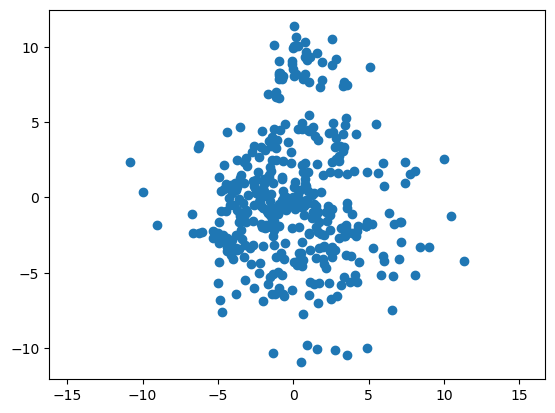

In [8]:
plt.scatter(proj_faces[:,0], proj_faces[:,1])
_ = plt.axis('equal')

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,10*2), sharex=True)
centered_faces = faces - faces.mean(0)
axes[0].imshow(rec_faces[2].reshape(64,64))
axes[1].imshow(centered_faces[2].reshape(64,64))

## MDS
For MDS (and IsoMap) you will compute 2D embeddings of the 3D S dataset shown below. To this end implement the `mds` function that takes a Euclidean distance matrix as input and the number of dimensions of the lower dimensional embedding space (i.e. `n_comps`). For a 2D plot choose `n_comps = 2`. To compute the eigendecomposition you can use `np.linalg.eigh` (see the documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)). To construct an identity matrix use `np.eye`. To generate a constant one matrix use `np.ones` or `np.ones_like`. For other mathematical operations you might need refer to the numpy documentation.

The colors are added to the 3D and 2D scatter plots to make it easier for you to verify your results.

In [ ]:
s_curve = np.load("s.npy")

In [ ]:
colors = k3d.helpers.map_colors(s_curve[:,-1], k3d.colormaps.matplotlib_color_maps.viridis).astype(np.uint32)
k3d.points(s_curve.astype(np.float32), colors=colors, point_size=0.1)

We can compute the Euclidean distance matrix for the 3D points like this:

In [ ]:
dists = cdist(s_curve, s_curve, 'euclidean')
print(dists.shape)

In [ ]:
def mds(dists, n_comps):
    ### YOUR CODE HERE
    n = dists.shape[0]
    J = np.eye(n) - np.ones((n, n))/n
    B = (-0.5)*(J@np.square(dists)@J)
    #print(sq_dists.shape)
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    eigenindex = np.argsort(eigenvalues)[-n_comps:]
    v = eigenvectors[:, eigenindex]
    
    #print(v.shape)
    
    eigval = np.sqrt(eigenvalues[[eigenindex]])
    
    #print(eigval.shape)
    X = np.multiply(v, eigval)
    #print(X.shape)
    
    return X
    

In [ ]:
s_emb = mds(dists, 2)
assert s_emb.shape == (dists.shape[0], 2)

In [ ]:
plt.scatter(s_emb[:,0], s_emb[:,1], c=colors)
_ = plt.axis('equal')

## IsoMap
We will now apply IsoMap to the same S 3D dataset and compute a 2D embedding. The shortest path distance matrix can be computed for the pairwise graph distances on a neighbourhood graph with the given `shortest_path_dists` function. It takes the previously computed Euclidean distance matrix and a `eps` value that determines if points are connected by an edge or not. We recommend for you to set `eps = 0.35`. 

In [ ]:
def shortest_path_dists(dists, eps=0.35):
    rows = []
    cols = []
    data = []
    for i in range(dists.shape[0]):
        for j in range(i+1, dists.shape[0]):
            if dists[i,j] <= eps:
                rows.append(i)
                cols.append(j)
                data.append(dists[i,j])
                rows.append(j)
                cols.append(i)
                data.append(dists[i,j])
    adj_matrix = csr_matrix((data, (rows, cols)), shape=dists.shape)
    path_dists = shortest_path(adj_matrix, directed=False)
    return path_dists

def isomap(dists, n_comps):
    ### YOUR CODE HERE
    spdists = shortest_path_dists(dists)
    X = mds(spdists, n_comps)
    return X
    

In [ ]:
s_emb_iso = isomap(dists, 2)
assert s_emb_iso.shape == (dists.shape[0], 2)

In [ ]:
plt.scatter(s_emb_iso[:,0], s_emb_iso[:,1], c=colors)
_ = plt.axis('equal')